## Generating Personalized Book Recommendations from a Book Dataset 
#### Preprocessing
- Bad data, duplicates, and outliers dealt with
- Future potential to feature engineer new "category" feature
    - currently takes too long to be achievable for this project
- Binned continous numerical features
    - Recommendations based on these features is a possibility

#### Can generate recommendations in 3 ways:
1) User-ID:
    - A user can enter their (or someone elses) User-ID to show a highly rated book from 5 similar users - Collaborative filtering
2) Book-Title:
    - A user can enter a book title and be recommended 5 similar books - Collaborative filtering
3) Top 10 most popular books:
    - A user can simply view the 10 most popular books

#### Evaluation
- Both collaborative filtering based recommenders work as expected
    - When tested on entering Book-Title, the item based recommender recommends books that are similar (human judgement)
    - When tested on User-ID, the other recommender recommends highly rated books from similar users (human judgement)
    - The top 10 most popular books are output sucessfully (human judgement)

#### User Interface
- All recommenders have a test cell to input different user-IDs/book-Titles and view the outputs easily
    - This could be improved by implementing them into a Flask webapp but this was not possible in the time frame I had
    - I would have ideally liked a feedback option for users to rate whether the recommendations were relevant to them or not
        - this could be used to create an evaluation metric showing how well the model performs
            - would require substantial user testing to get a good understanding of performance

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading in the dataset

In [2]:
book_df = pd.read_csv('Books.csv', sep=',', on_bad_lines = 'skip')
ratings_df = pd.read_csv('Ratings.csv', sep=',', on_bad_lines = 'skip')
users_df = pd.read_csv('Users.csv', sep=',', on_bad_lines = 'skip')

C:\Users\toyal\AppData\Local\Temp\ipykernel_27644\3711711085.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_df = pd.read_csv('Books.csv', sep=',', on_bad_lines = 'skip')


#### Feature Engineering
- Can use Google's Book API to create a "category" column
- This takes 2-3 hours to run so was infeasible with this project

In [3]:
# import urllib.request
# import json

# base_api_link = "https://www.googleapis.com/books/v1/volumes?q=isbn:"

# def get_category(isbn):
#     with urllib.request.urlopen(base_api_link + isbn) as f:
#         text = f.read()
#     decoded_text = text.decode("utf-8")
#     obj = json.loads(decoded_text)
#     try:
#         volume_info = obj["items"][0] 
#         print(volume_info["volumeInfo"]["categories"])
#         # displays title, summary, author, domain, page count and language
#         return volume_info["volumeInfo"]["categories"]
#     except:
#         return 'Missing'

# #book_df['category'] = book_df.apply(lambda row: get_category(row.isbn), axis=1)

# # vectorize is faster than apply, but API request is still too slow    
# get_category_vectorized = np.vectorize(get_category)
# book_df['category'] = get_category_vectorized(book_df['isbn'])


#### Dropping irrelevant columns

In [4]:
book_df.drop(columns=['Image-URL-S','Image-URL-M','Image-URL-L'], inplace=True)
book_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


#### Changing location to country to simplify
- in future could create recommendations based on country or age
    - so these features are good to keep

In [5]:
users_df['Country'] = users_df['Location'].str.split(',').str[-1].str.strip()
users_df.drop(columns=['Location'], inplace=True)
users_df.head(5)

,User-ID,Age,Country
0,1,NaN,usa
1,2,18.0,usa
2,3,NaN,russia
3,4,17.0,portugal
4,5,NaN,united kingdom


#### Check cardinality of categorical columns

In [6]:
book_df[['ISBN','Book-Title','Book-Author','Publisher']].nunique()

ISBN           271360
Book-Title     242135
Book-Author    102023
Publisher       16807
dtype: int64

In [7]:
users_df[['Country']].nunique()

Country    709
dtype: int64

#### Checking for 0s where unexpected
- 3570 books have no publication year
- remove these as imputation would be misleading

In [8]:
book_df[book_df == 0].count() 

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication    3570
Publisher                 0
dtype: int64

In [9]:
book_df = book_df[book_df['Year-Of-Publication'] != 0]

#### Check for nulls
##### book_df:
- 2 null authors
- 2 null 
##### ratings_df:
- 0 null
##### users_df:
- 39.5% of users have null age
- impute with -1 temporarily, this will be binned as "Missing" later

In [10]:
book_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [11]:
book_df = book_df[book_df['Book-Author'].notna() & book_df['Publisher'].notna()]

In [12]:
ratings_df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [13]:
users_df.isnull().sum()

User-ID         0
Age        110762
Country         0
dtype: int64

In [14]:
# filling missing age as -1 to later bin as missing
users_df['Age'] = users_df['Age'].fillna(-1)

#### Checking types of dataframe columns
- book_df Year-Of-Publication should be numeric, contains str errors
- ratings_df change User-ID to object

In [15]:
book_df.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
dtype: object

In [16]:
book_df[['Year-Of-Publication']] = book_df[['Year-Of-Publication']].apply(pd.to_numeric, errors='coerce')
book_df = book_df[book_df['Year-Of-Publication'].notna()]
book_df['Year-Of-Publication'] = book_df['Year-Of-Publication'].astype(int)

In [17]:
ratings_df.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

In [18]:
ratings_df['User-ID'] = ratings_df['User-ID'].astype(str)

In [19]:
users_df.dtypes

User-ID      int64
Age        float64
Country     object
dtype: object

In [20]:
users_df['User-ID'] = users_df['User-ID'].astype(str)

#### Check for negatives on numerical columns
- None present

In [21]:
(book_df[['Year-Of-Publication']].values < 0).any()

False

In [22]:
(ratings_df[['Book-Rating']].values < 0).any()

False

In [23]:
# Expected to contain below 0
# check if contains below -1
(users_df[['Age']].values < -1).any()

False

#### Checking for duplicated rows and duplicated ISBN/User-IDs
- 0 duplicates

In [24]:
len(book_df[book_df.duplicated()])

0

In [25]:
len(ratings_df[ratings_df.duplicated()])

0

In [26]:
len(users_df[users_df.duplicated()])

0

In [27]:
# book_df.duplicated(subset=['ISBN']).any() # = False
# users_df.duplicated(subset=['User-ID']).any() # = False


#### Visualising the distribution of numerical columns and checking skew
- Can see book_df Year-Of-Publication and user_df Age suffer from skew greater than 2 or less than -2
- remove outliers in Age fixes this problem
- likely 0 rating is a placeholder for unreviewed so remove rows with a 0 rating

Year-Of-Publication   -15.785953
dtype: float64
Book-Rating    0.733641
dtype: float64
Age    0.583422
dtype: float64


Text(0.5, 1.0, 'Age')

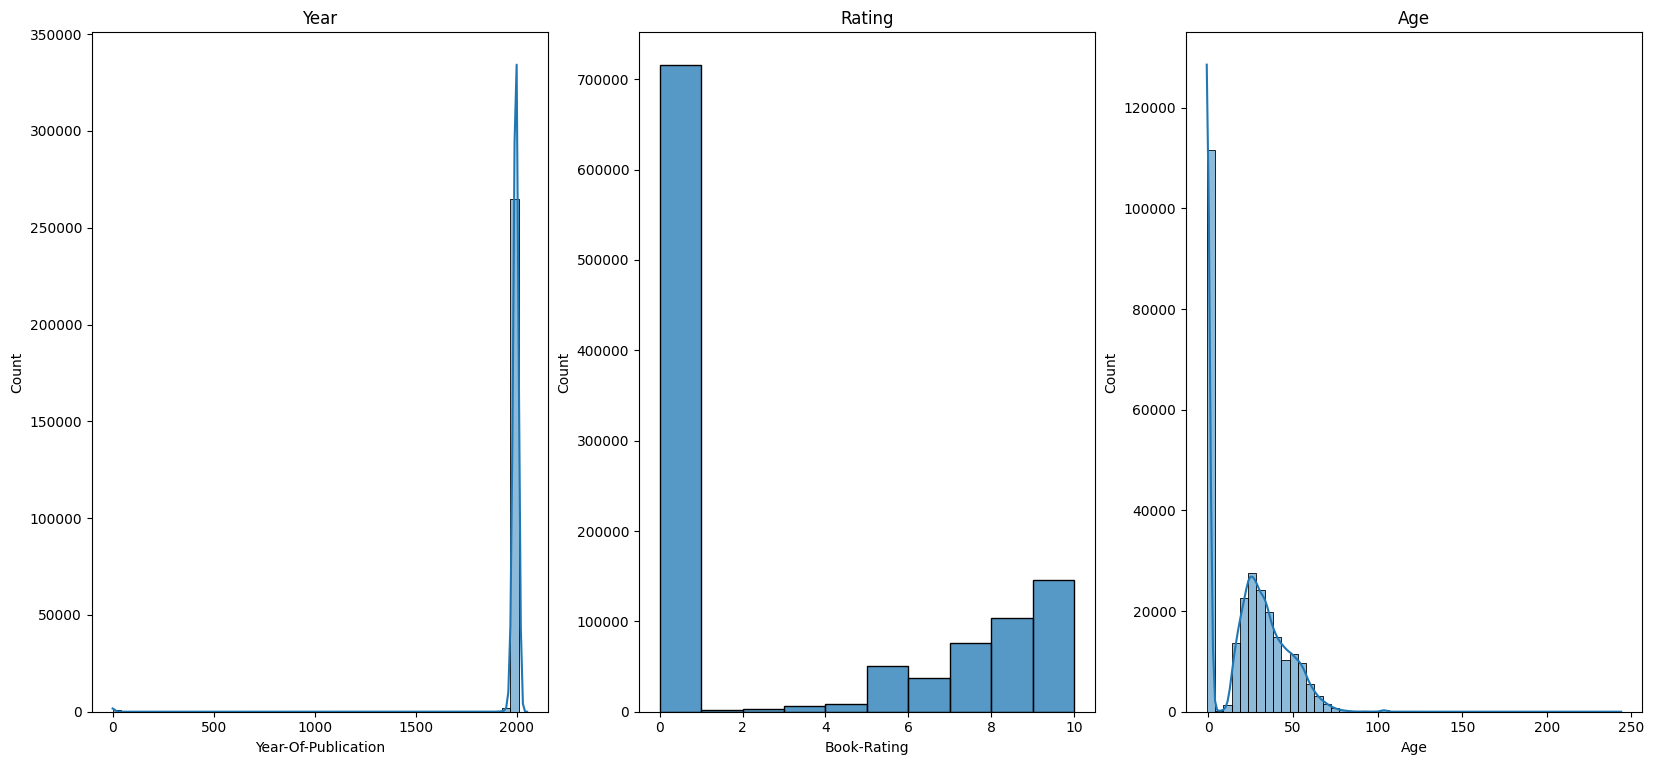

In [28]:
print(book_df[['Year-Of-Publication']].skew())
print(ratings_df[['Book-Rating']].skew())
print(users_df[['Age']].skew())

fig = plt.figure(figsize=(20,30))

plt.subplot(3,3,1)
sns.histplot(book_df['Year-Of-Publication'], bins = 50, kde = True)
plt.title("Year")

plt.subplot(3,3,2)
sns.histplot(ratings_df['Book-Rating'], bins = 10)
plt.title("Rating")

plt.subplot(3,3,3)
sns.histplot(users_df['Age'], bins = 50, kde = True)
plt.title("Age")

In [29]:
# winsorise age - removing the impossible ages is not ideal
users_df['Age'] = winsorize(users_df['Age'], limits=[0, 0.0015])
# winsorising year of publication to deal with outliers
book_df['Year-Of-Publication'] = winsorize(book_df['Year-Of-Publication'], limits=[0.0025, 0.0025])
# remove ratings of 0
ratings_df = ratings_df[ratings_df['Book-Rating']!=0]

#### Checking skew
- Year-Of-Publication is highly negatively skewed
    - This is okay for this project

In [30]:
print(book_df[['Year-Of-Publication']].skew())
print(ratings_df[['Book-Rating']].skew())
print(users_df[['Age']].skew())

Year-Of-Publication   -15.786095
dtype: float64
Book-Rating   -0.655615
dtype: float64
Age    0.454231
dtype: float64


#### Bin publication year and age

In [31]:
age_edges = [-2, 0, 15, 30, 45, 60, 75, 90, 400]
age_labels = ['Missing','0-14','15-29','30-44','45-59','60-74','75-89','90+']
users_df['Age'] = pd.cut(users_df['Age'], age_edges, right=False, labels=age_labels).astype(str)

year_edges = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
year_labels = ['50s or earlier','60s','70s','80s','90s','00s']
book_df['Year-Of-Publication'] = pd.cut(book_df['Year-Of-Publication'], year_edges, right=False, labels= year_labels).astype(str)

Text(0.5, 1.0, 'Age')

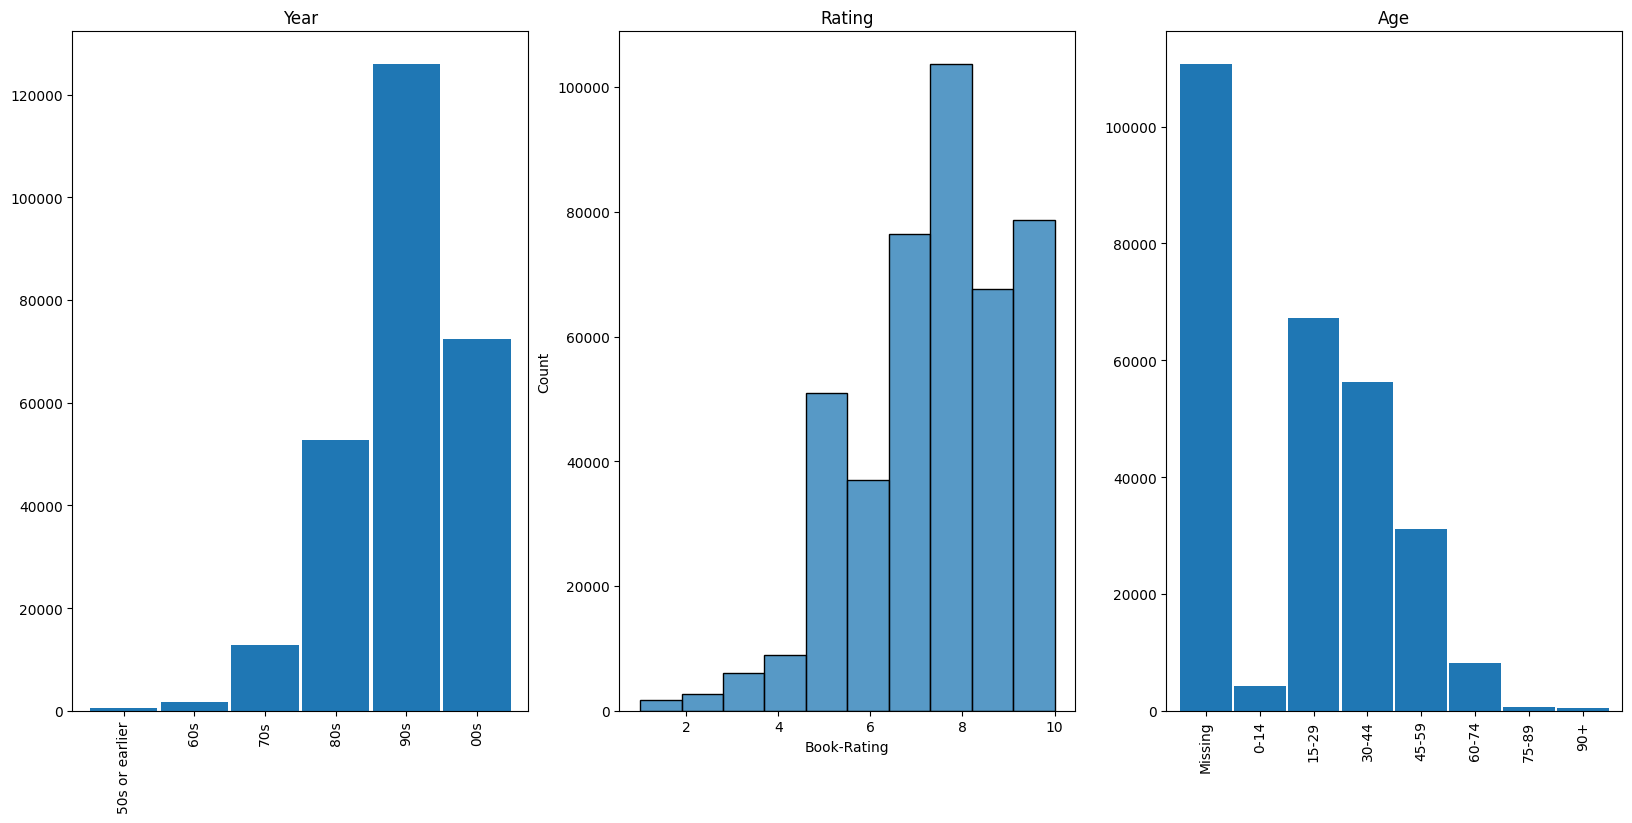

In [32]:
fig = plt.figure(figsize=(20,30))

plt.subplot(3,3,1)
book_df['Year-Of-Publication'].value_counts(sort=False).loc[year_labels].plot(kind='bar', width=0.95)
plt.title("Year")

plt.subplot(3,3,2)
sns.histplot(ratings_df['Book-Rating'], bins = 10)
plt.title("Rating")

plt.subplot(3,3,3)
users_df['Age'].value_counts(sort=False).loc[age_labels].plot(kind='bar', width=0.96)
plt.title("Age")

## Recommender system
- Can recommend books based on:
    - Book-Name
    - User-ID
- Also show:
    - 10 most popular books including number of ratings and average rating

#### Merge the 3 dataframes into 1

In [33]:
ratings_books_merge_df = ratings_df.merge(book_df,on='ISBN')
ratings_books_merge_df.drop(columns='ISBN',axis=1,inplace=True)
df = ratings_books_merge_df.merge(users_df, on="User-ID")
df.head(5)


,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,Country
0,276726,5,Rites of Passage,Judith Rae,00s,Heinle,Missing,usa
1,276729,3,Help!: Level 1,Philip Prowse,90s,Cambridge University Press,15-29,croatia
2,276729,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,00s,Cambridge University Press,15-29,croatia
3,276744,7,A Painted House,JOHN GRISHAM,00s,Doubleday,Missing,usa
4,11676,10,A Painted House,JOHN GRISHAM,00s,Doubleday,Missing,n/a


### Item based recommendations
- Recommend similar books to the specified book by finding popular books that have scored similarly by knowledgeable users

In [34]:
from sklearn.metrics.pairwise import cosine_similarity 

# get indices of knowledgable users
x = df.groupby('User-ID').count()['Book-Rating']>100
knowledgable_users = x[x].index

# filter df to only contain knowledgeable users
filtered_rating = df[df['User-ID'].isin(knowledgable_users)]

# filter so that only books with over 10 reviews are present (popular books)
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=11
popular_books = y[y].index
final_ratings =  filtered_rating[filtered_rating['Book-Title'].isin(popular_books)]

# create a pivot table of knowledgeable users and popular books
book_pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID'
                          ,values='Book-Rating')
book_pt.fillna(0,inplace=True)

# create a matrix of books cosine similarity to one another
book_similarity_score = cosine_similarity(book_pt)

In [35]:
def recommend(book_name):
    if book_name not in final_ratings["Book-Title"].values:
        print("Book not found")
    else:
        index = np.where(book_pt.index==book_name)[0][0]
        # use index to return the 5 top scoring books from a sorted list of similarity scores of other books
        similar_books = sorted(list(enumerate(book_similarity_score[index])),key=lambda x:x[1], reverse=True)[1:6]

        recommended_books = [f'\033[4mBased on "{book_name}", you may like the following books:\033[0m']
        
        # return the titles and authors of 5 similar books 
        for i in similar_books:
            temp_df = book_df[book_df['Book-Title'] == book_pt.index[i[0]]]
            recommended_books.append(str(temp_df.drop_duplicates('Book-Title')['Book-Title'].values[0]))
        return print('\n'.join(map(str, recommended_books)))

#### Test area
- Input test books
- Works as expected:
    - Harry potter returns other Harry potter books
    - 1984 returns similar dystopian books like Brave New World
    - The Hobbit returns similar books like The Lord of the Rings

In [36]:
# Test books:
# "Harry Potter and the Chamber of Secrets (Book 2)"
# "1984"
# "Brave New World"
# "The Hobbit"
# "The Fellowship of the Ring (The Lord of the Rings, Part 1)"

recommend("The Hobbit")

Based on "The Hobbit", you may like the following books:
The Return of the King (The Lord of the Rings, Part 3)
Brave New World
The Girl Who Loved Tom Gordon
God Emperor of Dune (Dune Chronicles, Book 4)
The Edible Woman


#### User based recommendations
- input user ID to return the top book of 5 similar users


In [38]:
# keep only users who vote more than 100 times
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 100]  

# create pivot table of knowledgeable users with their book ratings
users_pt=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_pt.fillna(0,inplace=True)

In [38]:

user_similarity=cosine_similarity(users_pt)

def user_based(id):
    if id not in new_df["User-ID"].values:
        print("User not found")
        
    else:
        index=np.where(users_pt.index == id)[0][0]
        
        # use index to return the 5 top scoring users from a sorted list of similarity scores of other users
        similar_users= sorted(list(enumerate(user_similarity[index])), key = lambda x:x[1], reverse=True)[1:6]
    
        user_rec=[]
    
        for i in similar_users:
                # get similar users book data
                data=df[df["User-ID"] == users_pt.index[i[0]]]
                user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))

        
        x = new_df[new_df["User-ID"]==id]
        recommended_books = [f'\033[4mBased on user id:"{id}", you may like the following books:\033[0m']
        user = list(user_rec)

        # for each similar user, sort their books and choose the top book to recommend
        for i in user:
            y = new_df[(new_df["User-ID"]==i)]
            books = (y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]).sort_values(["Book-Rating"],ascending=False)[0:1]
            recommended_books.extend(books["Book-Title"].values)
        recommended_books = recommended_books
    return print('\n'.join(map(str, recommended_books)))

#### Test Area
- input test user IDs
- output works as expected, showing the top book from 5 similar users

In [39]:
# Test User-IDs:
# "16795"
# "11676"
# "114368"
# "69389"

user_based('69389')

Based on user id:"69389", you may like the following books:
Secrets
Eyes of Prey
The Green Mile
Violets Are Blue
J is for Judgment


#### Most popular books
- create a dataframe containings number of ratings and average rating
- output the 10 most popular books, with their average rating
- this will be useful to a user wanting to view popular books

In [40]:
number_ratings_df = df.groupby('Book-Title').count()['Book-Rating'].reset_index()
number_ratings_df.columns = ['Book-Title', 'Number-Ratings']

average_ratings_df = df.groupby('Book-Title').mean(numeric_only=True)['Book-Rating'].reset_index()
average_ratings_df.columns = ['Book-Title','Average-Rating']

book_scores_df = number_ratings_df.merge(average_ratings_df, on='Book-Title').sort_values(by=['Number-Ratings'], ascending=False).reset_index(drop=True)


In [41]:
top_10_books = book_scores_df.iloc[0:10]
top_10_books_output = [f'\033[4mThese are the 10 most popular books:\033[0m']
for i in range(10):
    top_10_books_output.append(f'\n{i+1})\n')
    top_10_books_output.append('\033[4mTitle:\033[0m ')
    top_10_books_output.append(str(top_10_books.iloc[i]['Book-Title']))
    top_10_books_output.append(' \033[4mNumber of Ratings:\033[0m ')
    top_10_books_output.append(str(top_10_books.iloc[i]['Number-Ratings']))
    top_10_books_output.append(' \033[4mAverage Rating:\033[0m ')
    top_10_books_output.append(str(top_10_books.iloc[i]['Average-Rating']))
print(''.join(map(str, top_10_books_output)))

These are the 10 most popular books:
1)
Title: The Lovely Bones: A Novel Number of Ratings: 707 Average Rating: 8.185289957567186
2)
Title: Wild Animus Number of Ratings: 581 Average Rating: 4.3907056798623065
3)
Title: The Da Vinci Code Number of Ratings: 494 Average Rating: 8.43927125506073
4)
Title: The Secret Life of Bees Number of Ratings: 406 Average Rating: 8.47783251231527
5)
Title: The Nanny Diaries: A Novel Number of Ratings: 393 Average Rating: 7.43765903307888
6)
Title: The Red Tent (Bestselling Backlist) Number of Ratings: 383 Average Rating: 8.182767624020888
7)
Title: Bridget Jones's Diary Number of Ratings: 377 Average Rating: 7.625994694960212
8)
Title: A Painted House Number of Ratings: 366 Average Rating: 7.398907103825136
9)
Title: Life of Pi Number of Ratings: 336 Average Rating: 8.080357142857142
10)
Title: Harry Potter and the Chamber of Secrets (Book 2) Number of Ratings: 326 Average Rating: 8.840490797546012
